In [3]:
import statsmodels.api as sm
import linearmodels as lm
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

path_ana_red = 'copy_master_data/Anagrafica_ClubQ8_red.csv'
path_premi_red = 'copy_master_data/Premi_ClubQ8_red.csv'
path_rif_red = 'copy_master_data/Rifornimenti_Carburante_ClubQ8_red.csv'

path_ana = 'master_data/Anagrafica_ClubQ8.csv'
path_premi = 'master_data/Premi_ClubQ8.csv'
path_rif = 'master_data/Rifornimenti_Carburante_ClubQ8.csv'

df1 = pd.read_csv(path_ana, sep=';', decimal = ',')
df1.head() #OK, works as expected and converts the decimals

df2 = pd.read_csv(path_premi, sep=';', decimal = ',')
df3 = pd.read_csv(path_rif, sep=';', decimal = ',')

In [4]:
#For reduced DB as there is an Unnamed column added when performing the function

#df1.drop(['Unnamed: 0'], axis = 1, inplace= True)
#df2.drop(['Unnamed: 0'], axis = 1, inplace= True)
#df3.drop(['Unnamed: 0'], axis = 1, inplace= True)

df1.head()

,COD_PAN_DA_POS,SEX,DATA_NASCITA,REGIONE,PROVINCIA,COMUNE,TIPO_CARTA,DATA_BATTESIMO,SALDO_PUNTI
0,7071161603018922195,M,1951-09-14 00:00:00,LAZIO,VITERBO,SUTRI,STARQ8_FISICA,2015-01-08 12:32:58,511.0
1,7071161603005992565,F,1988-09-15 00:00:00,NaN,NaN,NaN,STARQ8_FISICA,2020-07-10 12:22:35,379.0
2,7071161603025867243,F,1943-09-09 00:00:00,LAZIO,ROMA,ROMA,STARQ8_FISICA,2020-07-10 18:07:14,108.0
3,7071161603021997861,M,1974-03-01 00:00:00,SICILIA,MESSINA,MESSINA,STARQ8_FISICA,2020-07-10 18:08:21,100.0
4,7071161603025554049,M,1963-11-22 00:00:00,CAMPANIA,SALERNO,EBOLI,STARQ8_FISICA,2020-07-10 18:09:27,284.0


In [5]:
df2.columns

Index(['COD_PAN_DA_POS', 'DATA_OPERAZIONE', 'LUOGO_PRENOTAZIONE_PREMIO',
       'CATEGORIA', 'RAGGRUPPAMENTO_MERCEOLOGICO', 'DESCRIZIONE',
       'PUNTI_RICHIESTI', 'CONTRIBUTO_CLIENTE_CON_IVA'],
      dtype='object')

In [6]:
#df4 = pd.DataFrame(columns = 'Test')
df1['DATA_BATTESIMO'] = df1['DATA_BATTESIMO'].astype('datetime64')
df1['DATA_BATTESIMO'] = df1['DATA_BATTESIMO'].dt.date

df2['DATA_OPERAZIONE'] = df2['DATA_OPERAZIONE'].astype('datetime64')
df2['DATA_OPERAZIONE'] = df2['DATA_OPERAZIONE'].dt.date
df2.head()

,COD_PAN_DA_POS,DATA_OPERAZIONE,LUOGO_PRENOTAZIONE_PREMIO,CATEGORIA,RAGGRUPPAMENTO_MERCEOLOGICO,DESCRIZIONE,PUNTI_RICHIESTI,CONTRIBUTO_CLIENTE_CON_IVA
0,7071161603670014604,2020-09-01,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN
1,7071161603670014604,2020-09-01,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN
2,7071161603670014604,2020-09-01,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN
3,7071161603670014604,2020-09-01,ONLINE,PREMIO FISICO,PER LA TUA CASA,CONSEGNA CODICE GIFT CARDS 20E AMAZON,1800.0,NaN
4,7071161603014051338,2020-09-01,PUNTO VENDITA,PREMIO FISICO,PER TE,PRENOTAZIONE PORTA CARTE CREDITO SPARCO,450.0,0.0


In [7]:
df3['DATA_OPERAZIONE'] = df3['DATA_OPERAZIONE'].astype('datetime64')
df3['DATA_OPERAZIONE'] = df3['DATA_OPERAZIONE'].dt.date
df3.head()

df2.sort_values(by=['DATA_OPERAZIONE'], inplace=True, ascending=False)
df2.drop_duplicates('COD_PAN_DA_POS', keep='first', inplace=True)

df4 = df2.merge(df3, how='inner', on='COD_PAN_DA_POS')
print(df4.columns)
df4 = df4.iloc[:,[0,1,9,12]]

cols = df4.columns.tolist()
new_cols = [cols[2], cols[3], cols[0], cols[1]]
df4 = df4[new_cols]
df4 = df4.rename(columns={'DATA_OPERAZIONE_y': 'Date of gas purchase', 'LITRI': 'Gas Purchase in liters', 'COD_PAN_DA_POS': 'Unique Customer Identifier', 'DATA_OPERAZIONE_x': 'Date of first prize claim'})

df4['Date difference'] = df4['Date of gas purchase'].sub(df4['Date of first prize claim'], axis = 0)
print(df4.dtypes)
df4.head()

Index(['COD_PAN_DA_POS', 'DATA_OPERAZIONE_x', 'LUOGO_PRENOTAZIONE_PREMIO',
       'CATEGORIA', 'RAGGRUPPAMENTO_MERCEOLOGICO', 'DESCRIZIONE',
       'PUNTI_RICHIESTI', 'CONTRIBUTO_CLIENTE_CON_IVA', 'COD_PV',
       'DATA_OPERAZIONE_y', 'PRODOTTO', 'MODALITA_VENDITA', 'LITRI',
       'PUNTI_CARBURANTE'],
      dtype='object')
Date of gas purchase                   object
Gas Purchase in liters                  int64
Unique Customer Identifier              int64
Date of first prize claim              object
Date difference               timedelta64[ns]
dtype: object


,Date of gas purchase,Gas Purchase in liters,Unique Customer Identifier,Date of first prize claim,Date difference
0,2021-03-10,50,7071161603020806626,2021-08-31,-174 days
1,2021-03-24,45,7071161603020806626,2021-08-31,-160 days
2,2021-03-29,42,7071161603020806626,2021-08-31,-155 days
3,2021-04-01,50,7071161603020806626,2021-08-31,-152 days
4,2021-04-12,45,7071161603020806626,2021-08-31,-141 days


In [8]:
Y = df4.iloc[:,1].values.reshape(-1,1)
#df4['Date difference'] = df4['Date difference'].astype('float')  
df4['Date difference'] = df4['Date difference']  / np.timedelta64(1,'D')
print(df4.dtypes)
X = df4.iloc[:,4].values.reshape(-1,1)

#SkLearn LinearRegression
lr = LinearRegression()
e = np.random.normal(size=len(df4))
lr.fit(X,Y)
Y_pred = lr.predict(X)

#StatsModels OLS
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())
print("Parameters: ", results.params)
print("R2: ", results.rsquared)

Date of gas purchase           object
Gas Purchase in liters          int64
Unique Customer Identifier      int64
Date of first prize claim      object
Date difference               float64
dtype: object
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.039
Model:                            OLS   Adj. R-squared (uncentered):              0.039
Method:                 Least Squares   F-statistic:                          1.682e+05
Date:                Sun, 09 Jan 2022   Prob (F-statistic):                        0.00
Time:                        19:21:35   Log-Likelihood:                     -2.3198e+07
No. Observations:             4113141   AIC:                                  4.640e+07
Df Residuals:                 4113140   BIC:                                  4.640e+07
Df Model:                           1                                                  
Cova

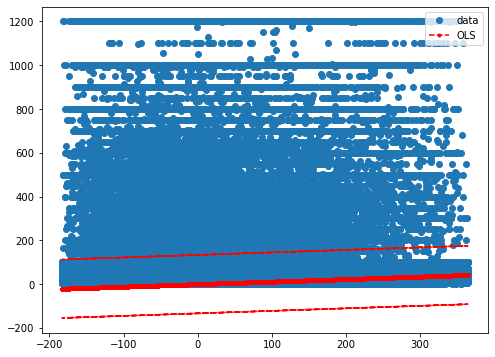

In [9]:
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(X, Y, "o", label="data")
#ax.plot(x, y_true, "b-", label="True")
ax.plot(X, results.fittedvalues, "r--.", label="OLS")
ax.plot(X, iv_u, "r--")
ax.plot(X, iv_l, "r--")
ax.legend(loc="best")
plt.show()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.064
Model:                            OLS   Adj. R-squared (uncentered):              0.063
Method:                 Least Squares   F-statistic:                              68.76
Date:                Sun, 09 Jan 2022   Prob (F-statistic):                    3.56e-16
Time:                        19:22:20   Log-Likelihood:                         -5503.2
No. Observations:                1000   AIC:                                  1.101e+04
Df Residuals:                     999   BIC:                                  1.101e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

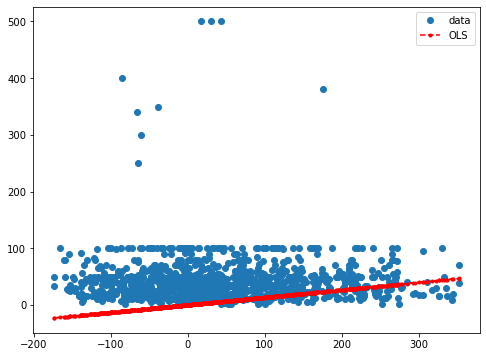

In [10]:
#Using a random sample from our data

df4sample = df4.sample(1000)
Ysample = df4sample.iloc[:,1].values.reshape(-1,1)
Xsample = df4sample.iloc[:,4].values.reshape(-1,1)

model = sm.OLS(Ysample, Xsample)
results = model.fit()
print(results.summary())
print("Parameters: ", results.params)
print("R2: ", results.rsquared)

pred_ols = results.get_prediction()
#iv_l = pred_ols.summary_frame()["obs_ci_lower"]
#iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(Xsample, Ysample, "o", label="data")
#ax.plot(x, y_true, "b-", label="True")
ax.plot(Xsample, results.fittedvalues, "r--.", label="OLS")
#ax.plot(Xsample, iv_u, "r--")
#ax.plot(Xsample, iv_l, "r--")
ax.legend(loc="best")
plt.show()

In [11]:
#Using PanelOLS regressor to take into account time-fixed and entity-fixed effects

df4=df4.set_index(['Date of gas purchase','Unique Customer Identifier'])
print(df4.head())
Y = df4['Gas Purchase in liters']
X = df4['Date difference']
print(Y)
print(X)
model = lm.PanelOLS(Y, X, entity_effects=True, time_effects=True).fit()
#results = model.fit()
print(results.summary())
print("Parameters: ", results.params)
print("R2: ", results.rsquared)

                                                 Gas Purchase in liters  \
Date of gas purchase Unique Customer Identifier                           
2021-03-10           7071161603020806626                             50   
2021-03-24           7071161603020806626                             45   
2021-03-29           7071161603020806626                             42   
2021-04-01           7071161603020806626                             50   
2021-04-12           7071161603020806626                             45   

                                                Date of first prize claim  \
Date of gas purchase Unique Customer Identifier                             
2021-03-10           7071161603020806626                       2021-08-31   
2021-03-24           7071161603020806626                       2021-08-31   
2021-03-29           7071161603020806626                       2021-08-31   
2021-04-01           7071161603020806626                       2021-08-31   
2021-04-12  